In [1]:
%%capture  
import numpy as np  
import pandas as pd  
import re  
import chardet.universaldetector
import calendar
from IPython.display import display
pd.set_option("display.max_colwidth", None)
from rich import print    
from pprint import pprint
import category_encoders as ce
from sklearn import preprocessing
from sklearn.feature_selection import f_classif
from textblob import TextBlob, Blobber
from textblob.sentiments import NaiveBayesAnalyzer
from afinn import Afinn  
import nltk  
nltk.download([
    "names",
    "stopwords",
    "vader_lexicon",
    "wordnet",
    "movie_reviews"
    "omw-1.4",
    "punkt",
    "averaged_perceptron_tagger"
])  
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Visualization
import matplotlib.pyplot as plt  
import seaborn as sns  
%matplotlib inline  
import plotly  
import plotly.express as px  
import plotly.graph_objects as go
import plotly.figure_factory as ff  
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# Import geo services  
import geopy  
from geopy import distance  
from geopy.geocoders import Bing  # library import  
geolocator = Bing(
    api_key="ArAEkjZybNV7puDe4lgO9FsX8VssJ57er2SG0SvcuN3YxL0bZ5U9wZUtPlddLrVx"
)  
import folium  
from folium import Marker  
from folium.plugins import MarkerCluster  

# Modules for data split, train and evaluation of model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [2]:
# Set constants  
RANDOM_SEED = 42  # random seed set
DATA_DIR = "Data/"

In [3]:
# Load data  
df_train = pd.read_csv(DATA_DIR + "hotels_train.csv")
df_test = pd.read_csv(DATA_DIR + "hotels_test.csv")
sample_submission = pd.read_csv(DATA_DIR + "submission.csv")

In [4]:
# Join train and test data for feature engineering  
df_train["sample"] = 1  # train data mark  
df_test["sample"] = 0  # test data mark  
df_test["reviewer_score"] = 0  # the target variable in test data set 0  

data = pd.concat(                           # join datasets
                 [df_train, df_test],       
                 sort=False
                 ).reset_index(drop=True)

In [5]:
data.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

### "The Features Of The Hotels"
Look at missing data in **latitudes** and **longitudes** of hotels geo positions:

In [6]:
# Missing data count  
def get_nan_cols(df):
    """" Count missing data in dataframe by feature in percents """  
    
    features_null_percent = df.isnull().mean().round(5) * 100  
    cols_with_null = features_null_percent[
                        features_null_percent > 0].sort_values(ascending=False)  
    display(cols_with_null)  

In [8]:
# Look at missing data  
print("[magenta]Percents of missing data")
get_nan_cols(data)  
num = data[(data["lat"].isna()) | (data["lng"].isna())].shape[0]
print()
print(f"[magenta]Number of rows with missing data: [magenta bold]{num}")

Percents of missing data

lat    0.634
lng    0.634
dtype: float64

Number of rows with missing data: 3268

In [ ]:
hotels_null = pd.read_csv(DATA_DIR + "long_lang.csv", index_col="Unnamed: 0")

In [9]:
# Add filled data to main dataframe  
data = data.merge(hotels_null, how="left", on="hotel_name")  
data["lat"] = data["lat_x"].fillna(data["lat_y"])  # fix latitude  
data["lng"] = data["lng_x"].fillna(data["lng_y"])  # fix longitude  

# Drop unnecessary columns  
data.drop(
    columns=["lat_x", "lng_x", "lat_y", "lng_y", "hotel_address_y"], 
    inplace=True
)  

# Some makeup))
data.rename(
    columns={"hotel_address_x":"hotel_address"}, 
    inplace=True
)    

Unique hotels throughout dataframe

In [10]:
# Filter unique hotels in dataframe
hotels_unique = data[
                     ["hotel_address", "hotel_name", "lat", "lng"]
                    ].drop_duplicates()  

# Add the map  
#m_1 = folium.Map(
#    tiles="openstreetmap", 
#    zoom_start=5, 
#    location=[48.779124, 9.180090]
#)

# Add points to the map  
#hotels = MarkerCluster()  
#for idx, row in hotels_unique.iterrows():
#    hotels.add_child(Marker([row["lat"], row["lng"]]))  
#m_1.add_child(hotels)  
#m_1  

There are 1494 unique hotels with unique addresses in 6 cities. 2 new features would be created:<br>
city of hotel and distance to centre of city from hotel<br>
Data of city centres was get from: https://simplemaps.com/data/world-cities

In [11]:
# Set city of hotel
def get_city_hotel(address):
    """Get city from address"""  
    
    if "United Kingdom" in address:
        city = "London"  
    else:
        city = address.split()[-2]  
    return city

# The city of the hotel feature
hotels_unique["hotel_city"] = hotels_unique[
                                        "hotel_address"].apply(get_city_hotel)



# Import data of the centres of the cities
centres_data = pd.read_csv(DATA_DIR + "centres.csv")
print("[magenta]Dataset with centres coordinates")
display(centres_data)  

# Add centres of the cities  
hotels_unique = hotels_unique.merge(centres_data, how="left", on="hotel_city")  

# Create distance to centre feature
hotels_unique["cent_dist"] = hotels_unique.apply(
                                            lambda x: 
                                            distance.distance(           
                                                (x["lat"], x["lng"]),
                                                (x["cent_lat"], x["cent_lng"])
                                            ).km, 
                                            axis=1
)  

# Add data to main dataframe  
data = data.merge(hotels_unique, how="left", on=["hotel_name", "lat", "lng"])

# Drop unnecessary columns 
data.drop([
    "hotel_address_x", "hotel_address_y", "lat", "lng", "cent_lat", 
    "cent_lng","hotel_country"
    ], 
    axis=1, 
    inplace=True
)  

# Add city names to distinguish hotels with similar names  
data["hotel_name"] = data.apply(
                            lambda x: 
                            (x["hotel_name"] + ", " + x["hotel_city"]), 
                            axis=1
)

Dataset with centres coordinates

,hotel_country,hotel_city,cent_lat,cent_lng
0,United Kingdom,London,51.5072,-0.1275
1,France,Paris,48.8566,2.3522
2,Netherlands,Amsterdam,52.3667,4.8833
3,Italy,Milan,45.4669,9.1900
4,Austria,Vienna,48.2083,16.3725
5,Spain,Barcelona,41.3825,2.1769


Encode hotel names

In [12]:
# Choose unique hotels
mask = data["sample"] == 1 # as reviewers_score = 0 on sample = 0
hotels_unique = data[mask].groupby(
                                ["hotel_name", "total_number_of_reviews"]
                                )["reviewer_score"].agg(
                                    ["mean"]
                                    ).reset_index().rename(
                                        columns={"mean":"mean_rev_score"}
)  

mask_hotel = (hotels_unique["mean_rev_score"] >= 9) &\
                                (hotels_unique["total_number_of_reviews"] > 350)  
filtered_hotels = hotels_unique[mask_hotel]
print(f"[magenta]Number of filtered hotels: [magenta bold]{len(filtered_hotels)}")

# Create filtered hotel names feature
hotels_unique["h_name_fix"] = hotels_unique["hotel_name"].apply(
                                lambda name: name
                                if name in filtered_hotels["hotel_name"].values
                                else "other"
)  

uh = hotels_unique["h_name_fix"].nunique()  
print(f"[magenta]Number of result hotels categories: [magenta bold]{uh}")

# Hotel names encode  
hotels_unique["h_name_fix"] = hotels_unique["h_name_fix"].astype("category")  # for encoding

ord_encoder = ce.OrdinalEncoder()  
hotels_temp = ord_encoder.fit_transform(hotels_unique[["h_name_fix"]])  
hotels_temp.rename(columns = {"h_name_fix":"hotel_enc"}, inplace = True)  # to distinguish features  
hotels_unique = pd.concat([hotels_unique, hotels_temp], axis=1)   

# Drop unnecessary column  
hotels_unique.drop(["h_name_fix", "mean_rev_score"], axis=1, inplace=True)  

# Gather data into main dataframe  
data = data.merge(hotels_unique, how="left", on=[
                                    "hotel_name", "total_number_of_reviews"
                                    ]
)

Number of filtered hotels: 211

Number of result hotels categories: 212

Encode hotel cities

Divide cities into 3 groups by reviewers' scores:
1. Barcelona & Vienna: 3
2. Amsterdam & Milan: 2
3. London & Paris: 1

In [13]:
def city_enc(city):
    """ Encode cities """
    
    if (city == "Barcelona") or (city == "Vienna"):
        result = 3  
    if (city == "Amsterdam") or (city == "Milan"):
        result = 2  
    if (city == "London") or (city == "Paris"):
        result = 1  
    return result

data["hotel_city_enc"] = data["hotel_city"].apply(city_enc)   

As we know average_score and reviewers score, so we can calculate their ratio.<br>
If the ratio is less than 1, then the average score of the hotel is growning, and we would mark it with 1.<br>
In other cases(ratio is equal or more than 1) it will be marked with 0.

In [14]:
# Filter necessary data   
mask = data["sample"] == 1 # as reviewers_score = 0 on sample = 0
average_pivot = data[mask].groupby(
                                ["hotel_name", "average_score"]
                                )["reviewer_score"].agg(
                                    ["mean"]
                                    ).reset_index().rename(
                                        columns={"mean":"mean_rev_score"}
)  

# Calculate ratio of scores  
average_pivot["growth_index"] = round(
                                    average_pivot["average_score"]/
                                    average_pivot["mean_rev_score"], 
                                    3
)  

# Mark growth  
average_pivot["hotel_growth_enc"] = average_pivot["growth_index"].apply(
                                                    lambda x: 1 if x < 1 else 0
)  
print(f"[magenta]Result pivot_table")
display(average_pivot)  

# Drop unnecessary columns  
average_pivot.drop(["mean_rev_score", "growth_index"], axis=1, inplace=True)  

# Add new feature to main dataframe  
data = data.merge(average_pivot, how="left", on=["hotel_name", "average_score"])  

Result pivot_table

,hotel_name,average_score,mean_rev_score,growth_index,hotel_growth_enc
0,"11 Cadogan Gardens, London",8.7,8.988182,0.968,1
1,"1K Hotel, Paris",7.7,7.932432,0.971,1
2,"25hours Hotel beim MuseumsQuartier, Vienna",8.8,8.998614,0.978,1
3,"41, London",9.6,9.729870,0.987,1
4,"45 Park Lane Dorchester Collection, London",9.4,9.534783,0.986,1
...,...,...,...,...,...
1489,"citizenM London Bankside, London",9.1,9.110308,0.999,1
1490,"citizenM London Shoreditch, London",9.1,9.096314,1.000,0
1491,"citizenM Tower of London, London",9.1,9.124259,0.997,1
1492,"every hotel Piccadilly, London",8.8,8.975980,0.980,1


### "Fantastic Reviewers and Where to Find Them"

We have features: **additional_number_of_scoring**(scores without reviews) and **total_number_of_reviews**(scores with reviews).<br>
Well, scores without reviews are rather **suspicious**, so let's calculate the ratio of number of scores without reviews and number of all scores. 

In [15]:
# Number of all scores
all_scores = data["additional_number_of_scoring"] + data["total_number_of_reviews"]  

# Calculate ratio of scores in percents  
data["score_ratio"] = round(                                  
                            data["additional_number_of_scoring"]/all_scores, 
                            2
                           ) * 100  
print(f"[magenta]Unique ratio values")
pprint(data["score_ratio"].value_counts(), width=79, compact=True)  

""" 
    There are different values from 2 percents to 28 percents.
    I think it is very suspicious, when ratio was higher than 25 percents.
    So let's divide ratios in 3 groups:
    ratio <= 20%, 20 < ratio < 25, ratio >= 25%  
    
"""

# Encode level of suspicion  
def ratio_encoding(ratio):
    """ Encode level of suspicion """  
    
    if ratio <= 20:
        x = 0  
    if (ratio > 20) and (ratio < 25):
        x = 1  
    if ratio >= 25:
        x = 2  
    return x  


data["suspicion_enc"] = data["score_ratio"].apply(ratio_encoding)  

data.drop(["score_ratio"], axis=1, inplace=True)  

print()  
print(f"[magenta]Amount of hotels by level of suspicion")
data["suspicion_enc"].value_counts()  # amount of hotels by level of suspicion  

Unique ratio values

19.0    44158
9.0     39392
18.0    35716
20.0    33675
8.0     30608
11.0    29992
10.0    27238
13.0    26718
23.0    25481
16.0    24901
12.0    24686
15.0    24123
14.0    23839
7.0     23550
21.0    22627
17.0    18701
22.0    14956
24.0    12717
6.0     11907
5.0      8697
25.0     8228
4.0      1932
26.0     1521
28.0      166
2.0        94
3.0        78
27.0       37
Name: score_ratio, dtype: int64


Amount of hotels by level of suspicion

0    430005
1     75781
2      9952
Name: suspicion_enc, dtype: int64

In [16]:
# Review_date fix  
data["review_date"] = pd.to_datetime(data["review_date"])
data["review_month"] = data["review_date"].apply(lambda x: x.month)

# Days_since_review fix  
data["days_since_review"] = data["days_since_review"].apply(
                                               lambda x: int(x.split()[0])
)  

# Drop unnecessary columns
data.drop(["review_date"], axis=1, inplace=True)

Now we will look at **reviewer nationality**.<br>
Reviewers' nationalities(countries) would be associated with their continents and thеn encoded.<br>
The data of countries and their continents was downloaded from: https://worldpopulationreview.com/country-rankings/list-of-countries-by-continent<br>
and adapted for our purposes. 

In [19]:
# Load data of countries by continents  
continents = pd.read_csv(DATA_DIR + "continents.csv")
print("[magenta]Data of countries by continents")
display(continents)  

# This is necessary as I found out later 
data["reviewer_nationality"] = data["reviewer_nationality"].apply(
                                                            lambda x: x.strip()
)  

# Add data to main dataframe  
data = data.merge(
                  continents, 
                  how="left", 
                  left_on="reviewer_nationality", 
                  right_on="country"
)  

# Now let's check our data
print("[magenta]Columns with nulls")
get_nan_cols(data)  
print()  
print("[magenta]Null data")
display(data.loc[data["continent"].isna(), "reviewer_nationality"].value_counts())

# Oooops! We have NaN data for unrecognized countries
# But the amount of missing values is rather small, 
# so just let's fill them with mode
data["continent"].fillna(data["continent"].mode()[0], inplace=True)

# Now let's look at the distribution of reviewers score by continents
#mask = data["sample"] == 1 # as reviewers_score = 0 on sample = 0
#fig = px.box(
#      data[mask],
#      x="reviewer_score",
#      y="continent",
#      color="continent", 
#      width=1300,
#      height=600,
#      labels={"reviewer_score":"Reviewers' Scores"}
#)  
#fig.update_layout(
#      font_family="Helvetica",
#      title={
#            "text":"Distribution of reviewers' scores by reviewers' continents",
#            "x":0.1, "xanchor":"left",
#            "y":0.98, "yanchor":"top",
#            },
#      xaxis=dict(tickfont_size=14),
#      yaxis=dict(tickfont_size=14, title=""),
#      legend=dict(
#            title="continets:", 
#            orientation="h", 
#            y=1, yanchor="bottom", 
#            x=1, xanchor="right"
#            )
#)  
#iplot(fig)  

Data of countries by continents

,country,continent
0,Algeria,Africa
1,Angola,Africa
2,Benin,Africa
3,Botswana,Africa
4,Burkina Faso,Africa
...,...,...
229,Paraguay,South America
230,Peru,South America
231,Suriname,South America
232,Uruguay,South America


Columns with nulls

country      0.254
continent    0.254
dtype: float64

Null data

                                        523
Macedonia                               282
Abkhazia Georgia                        153
United States Minor Outlying Islands     74
Kosovo                                   72
Palestinian Territory                    54
Cura ao                                  41
U S Virgin Islands                       17
Antigua Barbuda                          14
Turks Caicos Islands                     14
St Maarten                               11
Democratic Republic of the Congo          9
Swaziland                                 8
Crimea                                    6
Falkland Islands Malvinas                 6
East Timor                                4
Bonaire St Eustatius and Saba             3
Saint Barts                               3
Congo                                     3
Antarctica                                3
Central Africa Republic                   3
Saint Vincent Grenadines                  2
Cocos K I                       

As we can see above, there is very clear differentiation of reviewers scores by continents.<br>
Now let's encode continents by scoring

In [20]:
# Encode continents  
def continents_encode(continent):
    """ Encode reviewers' continents """  
    
    if continent == "North America":
        x = 6  
    if continent == "Oceania":
        x = 5  
    if continent == "South America":
        x = 4  
    if continent == "Africa":
        x = 3  
    if continent == "Europe":
        x = 2  
    if continent == "Asia":
        x = 1
    return x  


data["rev_continent_enc"] = data["continent"].apply(continents_encode) # encode reviewers' continents

# Drop unnecessary columns
data.drop(["reviewer_nationality", "country", "continent"], axis=1, inplace=True)

**"TAGS"**

In [21]:
# Tags overview  
def raw_tag_grab(tag):
    """ Get list of tags from raw string """  
    
    tag = tag.lower().lstrip("[' ").rstrip(" ']").replace("' ", "").replace(" '", "")
    lst = tag.split(",")
    tag_list = list(map(lambda t: t.strip(), lst))  
    return tag_list  

# Make column with list of tags  
data["tag_list"] = data["tags"].apply(raw_tag_grab)  

# Make column with number of tags  
data["num_tag"] = data["tag_list"].apply(lambda tag_list: len(tag_list))  

# Look at the structure of the tags  
mn = data["num_tag"].min()  
print(f"[magenta]The minimum number of tags: [magenta bold]{mn}")
print(data.loc[data["num_tag"] == 1, "tag_list"])  

print()  
mx = data["num_tag"].max()  
print(f"[magenta]The maximum number of tags: [magenta bold]{mx}")
print(data.loc[data["num_tag"] == 6, "tag_list"])  

The minimum number of tags: 1

69242                         [couple]
98745     [family with young children]
180550                         [group]
337200                        [couple]
380363                        [couple]
413505                         [group]
Name: tag_list, dtype: object


The maximum number of tags: 6

698                  [with a pet, leisure trip, solo traveler, standard double room, stayed 2 nights, submitted from a mobile device]
1276                           [with a pet, leisure trip, group, superior twin room, stayed 3 nights, submitted from a mobile device]
1407             [with a pet, leisure trip, family with young children, family room, stayed 3 nights, submitted from a mobile device]
2102        [with a pet, business trip, couple, king room with city view top floors, stayed 2 nights, submitted from a mobile device]
2281                                      [with a pet, leisure trip, group, 2 rooms, stayed 3 nights, submitted from a mobile device]
                                                                     ...                                                             
512523              [with a pet, leisure trip, couple, standard double or twin room, stayed 3 nights, submitted from a mobile device]
512524              [with a pet, leisure trip, couple, standar

**The maximum** number of tags is **6**. They have the structure:
 - with pet * 
 - type of trip *
 - type of reviewer
 - room description *
 - amount of stayed nights *
 - hotel room was submitted from a mobile device *<br>

\* - *maybe nothing if less than the maximum*

**The minimum** number of tags is **1**, there is only type of reviewer.<br>
Now we can encode this tags

In [22]:
# Encode with a pet tag  
def pet_tag_set(tag_list):
    """ Encode pet_tag """  
    
    if "with a pet" in tag_list:
        pet = 1  
        tag_list.remove("with a pet")  
    else:
        pet = 0  
    return pet  


# Encode type of trip tag  
def trip_tag_set(tag_list):
    """ Encode trip_tag """  
    
    if "leisure trip" in tag_list:
        trip = 2  
        tag_list.remove("leisure trip")  
    elif "business trip" in tag_list:
        trip = 1  
        tag_list.remove("business trip")  
    else:
        trip = 0  
    return trip  


# Encode number of stayed nights tag  
def nights_tag_set(tag_list):
    """ Encode nights_tag """  
    
    for tag in tag_list:
        if re.match(r"stayed\s\d+\snights?", tag):
            nights = int(re.findall(r".(\d+).*", tag)[0])  
            tag_list.remove(tag)  
        else:
                nights = 0  
    return nights  


# Encode submitted from a mobile device tag  
def mob_dev_tag_set(tag_list):
    """ Encode mob_dev_tag """  
    
    if "submitted from a mobile device" in tag_list:
        mob_dev = 1  
        tag_list.remove("submitted from a mobile device")  
    else:
        mob_dev = 0  
    return mob_dev  


# Apply functions and print some values  
data["pet_tag"] = data["tag_list"].apply(pet_tag_set)   
sum_pet = data["pet_tag"].sum()  
print(f"[magenta]Number of reviewers with pet: [magenta bold]{sum_pet}")

data["trip_tag"] = data["tag_list"].apply(trip_tag_set)  
bus_trip = data.loc[data["trip_tag"] == 1, "trip_tag"].count()  
print(f"[magenta]Number of reviewers on a business trip: [magenta bold]{bus_trip}")

data["nights_tag"] = data["tag_list"].apply(nights_tag_set)  
nght = data.loc[data["nights_tag"] == 1, "nights_tag"].count()  
print(f"[magenta]Number of reviewers stayed for 1 night: [magenta bold]{nght}")

data["mob_dev_tag"] = data["tag_list"].apply(mob_dev_tag_set)  
mob_dev = data["mob_dev_tag"].sum()  
print(
    f"[magenta]Number of reviewers submitted from a mobile device: \
[magenta bold]{mob_dev}"
)

Number of reviewers with pet: 1405

Number of reviewers on a business trip: 82939

Number of reviewers stayed for 1 night: 193645

Number of reviewers submitted from a mobile device: 307640

In [23]:
# Get sets of unique reviewers' types and types of rooms  
room_set = set()  
traveller_set = set()  

def room_type_grab(tag_list):
    """ Fill set of types of rooms tag """  
    global room_set  
    if len(tag_list) > 1:
        room_set.add(tag_list[1])  
        
def trav_type_grab(tag_list):
    """ Fill set of reviewers' types tag """  
    global traveller_set  
    traveller_set.add(tag_list[0])  


# Apply functions and print results
data["tag_list"].apply(room_type_grab)  
print(f"[magenta]Number of unique types of rooms: [magenta bold]{len(room_set)}")

data["tag_list"].apply(trav_type_grab)  
print(f"[magenta]Unique reviewers' types:\n[magenta bold]{traveller_set}")

# Create reviewer's type feature  
data["rev_type"] = data["tag_list"].apply(
                                          lambda x: x[0] 
                                          if (x[0] in traveller_set) 
                                          else "other"
)    

# Create features from type_of_room tag  
def type_of_room_set(tag_list):
    """ Create type of room feature """  
    
    types = ["premier", "superior", "deluxe", "classic", "guestroom", "standard", 
            "king", "queen", "club", "luxury", "suite", "executive", "junior", 
            "family", "basic"]  
    for tp in types:
        if len(tag_list) > 1:
            if tp in tag_list[1]:
                return tp  
            if ("no window" in tag_list[1]) or ("without window" in tag_list[1]):
                return "no window"  
    return "other"  

# Create type of room feature
data["room_type"] = data["tag_list"].apply(type_of_room_set)  

# Create double rooms feature  
data["roomX2"] = data["tag_list"].apply(
                                        lambda x: 1                                
                                        if ((len(x)>1) and (
                                            ("double" in x[1]) or  
                                            ("twin" in x[1]) or 
                                            ("duplex" in x[1])
                                            )
                                           ) 
                                        else 0
)  

# Create triple rooms feature  
data["roomX3"] = data["tag_list"].apply(
                                        lambda x: 1                           
                                        if ((len(x)>1) and ("triple" in x[1])) 
                                        else 0
)  

# Create quadruple rooms feature  
data["roomX4"] = data["tag_list"].apply(
                                        lambda x: 1                              
                                        if ((len(x)>1) and ("quadruple" in x[1])) 
                                        else 0
)  

# Create rooms with nice view feature  
data["with_view"] = data["tag_list"].apply(
                                           lambda x: 1                          
                                           if ((len(x)>1) and ("view" in x[1])) 
                                           else 0
)  

Number of unique types of rooms: 2380

Unique reviewers' types:
{'solo traveler', 'family with young children', 'family with older children', 'group', 'travelers with friends', 
'couple'}

In [24]:
# Encode reviewers' types and types of rooms  
# Reviewers' types  
rev_encoder = ce.OneHotEncoder(cols=["rev_type"], use_cat_names=True)  
rev_data= rev_encoder.fit_transform(data["rev_type"])  
data = pd.concat([data, rev_data], axis=1)  

# Types of rooms
room_encoder = ce.OneHotEncoder(cols=["room_type"], use_cat_names=True)  
room_data = room_encoder.fit_transform(data["room_type"])  
data = pd.concat([data, room_data], axis=1)  


# Make heavy light  
data[
     ["hotel_city_enc", "hotel_growth_enc", "suspicion_enc",
      "rev_continent_enc", "num_tag", "pet_tag", "trip_tag", "nights_tag", 
      "mob_dev_tag", "roomX2", "roomX3", "roomX4", "with_view", 
      "rev_type_couple", "rev_type_solo traveler", 
      "rev_type_family with young children","rev_type_group", 
      "rev_type_family with older children", "rev_type_travelers with friends", 
      "room_type_suite", "room_type_standard", "room_type_other", 
      "room_type_superior", "room_type_king", "room_type_luxury", 
      "room_type_executive", "room_type_family", "room_type_deluxe", 
      "room_type_no window", "room_type_premier", "room_type_basic", 
      "room_type_classic", "room_type_queen", "room_type_guestroom", 
      "room_type_club", "room_type_junior"]
    ] = data[
             ["hotel_city_enc", "hotel_growth_enc",
              "suspicion_enc", "rev_continent_enc", "num_tag", "pet_tag", 
              "trip_tag", "nights_tag", "mob_dev_tag", "roomX2", "roomX3", 
              "roomX4", "with_view", "rev_type_couple", "rev_type_solo traveler", 
              "rev_type_family with young children","rev_type_group", 
              "rev_type_family with older children", 
              "rev_type_travelers with friends", "room_type_suite", 
              "room_type_standard", "room_type_other", "room_type_superior", 
              "room_type_king", "room_type_luxury", "room_type_executive", 
              "room_type_family", "room_type_deluxe", "room_type_no window", 
              "room_type_premier", "room_type_basic", "room_type_classic", 
              "room_type_queen", "room_type_guestroom", "room_type_club", 
              "room_type_junior"]
            ].astype("int8")  

In [ ]:
# Distribution of reviewers' scores by lengths of tags
#mask = data["sample"] == 1 # as reviewers_score = 0 on sample = 0  
##fig = go.Figure()  
#fig.add_trace(go.Box(
#       y=data.loc[mask & (data["num_tag"] == 1), "reviewer_score"], 
#       name=" 1 tag "
#       )
#),  
#fig.add_trace(go.Box(
#       y=data.loc[mask & (data["num_tag"] == 2), "reviewer_score"], 
#       name=" 2 tags "
#       )
#),  
#fig.add_trace(go.Box(
#       y=data.loc[mask & (data["num_tag"] == 3), "reviewer_score"], 
#       name=" 3 tags "
#       )
#),  
#fig.add_trace(go.Box(
#       y=data.loc[mask & (data["num_tag"] == 4), "reviewer_score"], 
#       name=" 4 tags "
#       )
#),  
#fig.add_trace(go.Box(
#       y=data.loc[mask & (data["num_tag"] == 5), "reviewer_score"], 
#       name=" 5 tags "
#       )
#),  
#fig.add_trace(go.Box(
#       y=data.loc[mask & (data["num_tag"] == 6), "reviewer_score"], 
#       name=" 6 tags "
#       )
#)
#fig.update_layout(
#       font_family="Helvetica",
#       title={
#              "text":"Distribution of reviewers' scores by number of tags",
#              "x":0.07, "xanchor":"left",
#              "y":0.9, "yanchor":"top",
#              },
#       xaxis=dict(tickfont_size=14),
#       yaxis=dict(tickfont_size=14, title="Score"),
#       legend=dict(
#              title="number of tags:", 
#              orientation="h", 
#              y=1, yanchor="bottom", 
#              x=1, xanchor="right"
#              ),
#       width= 1300,
#       height= 600
#)  
#iplot(fig)

In [25]:

# There is direct correlation between reviewers' scores and number of tags
# So, let's encode them  
def num_tag_enc(length):
    
    if length == 1:
        result = 1  
    elif length == 2:
        result = 2  
    elif (length >= 3) and (length <= 5):
        result = 3  
    elif length == 6:
        result = 4  
    return result  

data["num_tag_enc"] = data["num_tag"].apply(num_tag_enc)  

In [ ]:
# Distribution of reviewers' scores by reviewers' types
#mask = data["sample"] == 1 # as reviewers_score = 0 on sample = 0  
#rev_types_pivot = pd.pivot_table(
#                                 data[mask],
#                                 index="rev_type", 
#                                 values="reviewer_score", 
#                                 aggfunc="mean"
#                                ).reset_index()
#
#
#fig = px.bar(
#      rev_types_pivot,
#      x="rev_type",
#      y=round(rev_types_pivot["reviewer_score"], 3),
#      color="rev_type",
#      labels={"rev_type":"Reviewers' types"},
#      width=1000,
#      height=600,
#      text_auto=True
#)
#fig.update_layout(
#      font_family="Helvetica",
#      title={
#            "text":"Distribution of reviewers' scores by reviewers' types",
#            "x":0.07, "xanchor":"left",
#            "y":0.97, "yanchor":"top",
#            },
#      xaxis=dict(tickfont_size=14),
#      yaxis=dict(tickfont_size=14, title="Scores"),
#      legend=dict(title="reviewers' types:")
#)  
#fig.update_traces(textfont_size=14, textposition="outside")  
#iplot(fig)  

Mean of reviewers' scores are mostly similar for each type of travellers. But the **lowest values** are for **solo travellers**<br>
and for **families with young children**. I think we have such result because people from this types have **less emotional involovement**<br>
and so they are **more critical**.

In [ ]:
# Distribution of reviewers' scores by types of rooms
#mask = data["sample"] == 1 # as reviewers_score = 0 on sample = 0
#room_types_pivot = pd.pivot_table(
#                                  data[mask],
#                                  index="room_type", 
#                                  values="reviewer_score", 
#                                  aggfunc="mean"
#                                 ).reset_index()
#
#
#fig = px.bar(
#       room_types_pivot,
#       x="room_type",
#       y=round(room_types_pivot["reviewer_score"], 2),
#       color="room_type",
#       labels={"room_type":"Types of Rooms"},
#       width=1300,
#       height=500,
#       text_auto=True
#)
#fig.update_layout(
#       font_family="Helvetica",
#       title={
#              "text":"Distribution of reviewers' scores by types of rooms",
#              "x":0.07, "xanchor":"left",
#              "y":0.97, "yanchor":"top",},
#       xaxis=dict(tickfont_size=14),
#       yaxis=dict(tickfont_size=14, title = "Scores"),
#       legend=dict(title="types of rooms:")
#)  
#fig.update_traces(textfont_size=14, textposition="outside")  
#iplot(fig) 

On the plot above we can mark such a thing: **the lowest scores** are for tags, which charcterize the rooms like **basic, guestroom or room without window**.<br> On the other hand **the highest scores** are for tags, which tell us about **premium segment** of rooms.<br>
I think, it’s pretty obvious.

In [26]:
# Drop unnecessary columns  
data.drop(
    ["tags" ,"tag_list", "room_type", "rev_type", "num_tag"], 
    axis=1, 
    inplace=True
)  

### Reviews: "No Negative" and "No Positive" 

In [27]:
# Some necessary code  
# Create a list of stopwords
garbage = nltk.corpus.stopwords.words("english")
garbage.extend([w.lower() for w in nltk.corpus.names.words()])

# Lemmatize with POS Tag
# For more correct lemmatization
#def get_wordnet_pos(word):
#    """ Map POS tag to first character lemmatize() accepts """
#
#    tag = nltk.pos_tag([word])[0][1][0].upper()
#    tag_dict = {"J": wordnet.ADJ,
#               "N": wordnet.NOUN,
#               "V": wordnet.VERB,
#               "R": wordnet.ADV}
#    return tag_dict.get(tag, wordnet.NOUN)

# Initialize Lemmatizer
#lemmatizer = WordNetLemmatizer()

In [43]:
# Some magic for better sentiment analysis
positive_words = list()
negative_words = list()

# Get unique positive words
def get_pos_words(text):
    global positive_words
    lst = text.split(" ")
    word_list = list(map(lambda w: w.strip(), lst))
    for word in word_list:
        positive_words.append(word)
    return None

# Get unique negative words
def get_neg_words(text):
    global negative_words
    lst = text.split(" ")
    word_list = list(map(lambda w: w.strip(), lst))
    for word in word_list:
        negative_words.append(word)
    return None

data["positive_review_fixed"].apply(get_pos_words)
data["negative_review_fixed"].apply(get_neg_words)

# Create frequency distributions for each list of words 
# and remove common words for both
positive_fd = nltk.FreqDist(positive_words)
negative_fd = nltk.FreqDist(negative_words)

print(
    F"[cyan]Initial number of words in positive_fd dictionary:[/cyan] \
[cyan bold]{len(positive_fd)}[/cyan bold]"
)
print(
    F"[cyan]Initial number of words in negative_fd dictionary:[/cyan] \
[cyan bold]{len(negative_fd)}[/cyan bold]"
)

common_words = set(positive_fd).intersection(negative_fd)
for word in common_words:
    del positive_fd[word]
    del negative_fd[word]
    
print(
    F"[cyan]Number of words in common_words set:[/cyan] \
[cyan bold]{len(common_words)}[/cyan bold]"
)
print(
    F"[cyan]Result number of words in positive_fd dictionary:[/cyan] \
[cyan bold]{len(positive_fd)}[/cyan bold]"
)
print(
    F"[cyan]Result number of words in negative_fd dictionary:[/cyan] \
[cyan bold]{len(negative_fd)}[/cyan bold]"
)

# Update nltk lexicon
# Choose 100 most common words from each fd-dictionary and add them
# into nltk lexicon

top_pos = {word for word, count in positive_fd.most_common(100)}
top_neg = {word for word, count in negative_fd.most_common(100)}

sia = SentimentIntensityAnalyzer()
print(
    F"[cyan]Default number of words in Sentiment Intensity Analyzer \
lexicon:[/cyan] [cyan bold]{len(sia.lexicon)}[/cyan bold]"
)

# Update positive words
for word in top_pos:
    if word in sia.lexicon:
        sia.lexicon[word] += 1
    else:
        sia.lexicon[word] = 1

# Update negative words
for word in top_neg:
    if word in sia.lexicon:
        sia.lexicon[word] -= 1
    else:
        sia.lexicon[word] = -1

print(
    f"[magenta]Number of words in Sentiment Intensity Analyzer lexicon after update:[/cyan] \
[cyan bold]{len(sia.lexicon)}[/cyan bold]"
)

Initial number of words in positive_fd dictionary: 46533

Initial number of words in negative_fd dictionary: 50292

Number of words in common_words set: 22992

Result number of words in positive_fd dictionary: 23541

Result number of words in negative_fd dictionary: 27300

Default number of words in Sentiment Intensity Analyzer lexicon: 7502

Number of words in Sentiment Intensity Analyzer lexicon after update: 7954

In [28]:
%%time
# Sentiment Intensity Analyzer with NLTK
sia = SentimentIntensityAnalyzer()

# Negative reviews Sentiment Intensity Analysis
data["negrev_sia_neg"] = data["negative_review"].apply(
                                lambda x: sia.polarity_scores(x)["neg"]
)
data["negrev_sia_neu"] = data["negative_review"].apply(
                                lambda x: sia.polarity_scores(x)["neu"]
)
data["negrev_sia_pos"] = data["negative_review"].apply(
                                lambda x: sia.polarity_scores(x)["pos"]
)
data["negrev_sia_compound"] = data["negative_review"].apply(
                                lambda x: sia.polarity_scores(x)["compound"]
)

# Positive reviews Sentiment Intensity Analysis
data["posrev_sia_neg"] = data["positive_review"].apply(
                                lambda x: sia.polarity_scores(x)["neg"]
)
data["posrev_sia_neu"] = data["positive_review"].apply(
                                lambda x: sia.polarity_scores(x)["neu"]
)
data["posrev_sia_pos"] = data["positive_review"].apply(
                                lambda x: sia.polarity_scores(x)["pos"]
)
data["posrev_sia_compound"] = data["positive_review"].apply(
                                lambda x: sia.polarity_scores(x)["compound"]
)

CPU times: user 17min 14s, sys: 1.25 s, total: 17min 15s
Wall time: 17min 16s


In [29]:
%%time
# Analyze data with Blobber
tb = Blobber(analyzer=NaiveBayesAnalyzer())

data["posrev_tb_neg"] = data["positive_review"].apply(
                                        lambda x: tb(x).sentiment.p_neg
)
data["posrev_tb_negclass"] = data["posrev_tb_neg"].apply(
                                        lambda x: 1 if x > 0.5 else 0
)
data["negrev_tb_neg"] = data["negative_review"].apply(
                                        lambda x: tb(x).sentiment.p_neg
)
data["negrev_tb_negclass"] = data["negrev_tb_neg"].apply(
                                        lambda x: 1 if x > 0.5 else 0
)

CPU times: user 5min 34s, sys: 896 ms, total: 5min 35s
Wall time: 5min 49s


In [30]:
%%time
# Positive review fix
def get_pos_rev(text):
    """ Prepare positive review for sentiment analysis """

    rev_str = str()
    neg_set = {                                                  # values mean negative
        "no positive", "na", "n a", "", " ", "nil", "no", "non",
        "nada", "nope", "zero", "none", "null", "none really",
        "no thing", "nothing", "nothing really"
    }

    # Correct some values for better analysis
    text = text.lower().strip()
    if len(text) <= 15:
        text = str(TextBlob(text).correct()) # correct spell

    for i in neg_set:
        if text == i:
            text = "negative"

    # Filter review text
    rev_lst = [word.strip() for word in nltk.word_tokenize(text)]
    for word in rev_lst:
        if word.isalpha() and (word not in garbage) and\
                (len(word) > 1) and ((word != "") or (word != " ")):
            #word = lemmatizer.lemmatize(word)#, get_wordnet_pos(word))
            rev_str = rev_str + word + " "
    return rev_str


data["positive_review_fixed"] = data["positive_review"].apply(get_pos_rev)

CPU times: user 19min 29s, sys: 1.74 s, total: 19min 30s
Wall time: 19min 31s


In [31]:
%%time
# Negative review fix
def get_neg_rev(text):
    """ Prepare negative review for sentiment analysis """

    rev_str = str()
    pos_set = {                                                  # values mean positive
        "no negative", "na", "n a", "", " ", "nil", "no", "non",
        "nada", "nope", "zero", "none", "null", "no complaints"
        "keinerlei beanstandung", "none really", "no thing",
        "nothing", "nothing really"
    }

    # Correct some values for better analysis
    text = text.lower().strip()
    if len(text) <= 15:
        text = str(TextBlob(text).correct())  # correct spell

    for i in pos_set:
        if text == i:
            text = "positive"

    # Filter review text
    rev_lst = [word.strip() for word in nltk.word_tokenize(text)]
    for word in rev_lst:
        if word.isalpha() and (word not in garbage) and\
                (len(word) > 1) and ((word != "") or (word != " ")):
            #word = lemmatizer.lemmatize(word)#, get_wordnet_pos(word))
            rev_str = rev_str + word + " "
    return rev_str


data["negative_review_fixed"] = data["negative_review"].apply(get_neg_rev)

CPU times: user 16min 41s, sys: 1.46 s, total: 16min 42s
Wall time: 16min 43s


In [32]:
%%time
# Count polarity and subjectivity with TextBlob
data["negrev_tb_pol"] = data["negative_review_fixed"].apply(
                                    lambda x: TextBlob(x).sentiment.polarity
)
data["negrev_tb_sub"] = data["negative_review_fixed"].apply(
                                    lambda x: TextBlob(x).sentiment.subjectivity
)
data["posrev_tb_pol"] = data["positive_review_fixed"].apply(
                                    lambda x: TextBlob(x).sentiment.polarity
)
data["posrev_tb_sub"] = data["positive_review_fixed"].apply(
                                    lambda x: TextBlob(x).sentiment.subjectivity
)

CPU times: user 7min 42s, sys: 580 ms, total: 7min 43s
Wall time: 7min 43s


In [33]:
%%time
# Afinn text analyzer

data["negative_review_tmp"] = data["negative_review"].apply(
                                              lambda x: x.replace("No Negative", "")
)
data["positive_review_tmp"] = data["positive_review"].apply(
                                              lambda x: x.replace("No Positive", "")
)
afinn = Afinn()
data["review_sum"] = data["negative_review_tmp"] + " " + data["positive_review_tmp"]
data["afinn_score"] = data["review_sum"].apply(lambda x: afinn.score(x))

# Limit the range of values by Tukey method
#def set_boundaries(df, feature):
#    """ Set boundaries of the range of values """
#    x = df[feature]
#    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
#    iqr = quartile_3 - quartile_1
#    lower_bound = quartile_1 - (iqr * 1.5)
#    upper_bound = quartile_3 + (iqr * 1.5)
#   return lower_bound, upper_bound


#lower_bound, upper_bound = set_boundaries(data, "afinn_score")

#data["afinn_score"] = data["afinn_score"].apply(
#                                lambda x: lower_bound
#                                if x < lower_bound
#                                else (upper_bound if x > upper_bound else x)
#)

CPU times: user 13min 35s, sys: 1.3 s, total: 13min 36s
Wall time: 13min 36s


### Reviews: "The Number"
Correlation of number of words in reviews and reviewers' scores

In [34]:
mask = data["sample"] == 1 # as reviewers_score = 0 on sample = 0
data_grp = data[mask].groupby(["reviewer_score"])[[
                            "review_total_negative_word_counts",
                            "review_total_positive_word_counts"
                            ]].agg({
                                "review_total_negative_word_counts":["max", "mean"],
                                "review_total_positive_word_counts":["max", "mean"],
                                }).reset_index()

nw_max = list(data_grp["review_total_negative_word_counts"]["max"].values)
nw_mean = list(round(data_grp["review_total_negative_word_counts"]["mean"]).values)

pw_max = list(data_grp["review_total_positive_word_counts"]["max"].values)
pw_mean = list(round(data_grp["review_total_positive_word_counts"]["mean"]).values)

scores = list(map(str, data_grp["reviewer_score"].values))

In [ ]:
# Plot the mean and the maximum of negative and positive words counts
#fig = make_subplots(rows=2, cols=2, specs=[[{'type': 'polar'}]*2]*2)
#fig.add_trace(go.Scatterpolar(
#    name = "Mean negative words count",
#    r = nw_mean,
#    theta = scores,
#), 1, 1)
#fig.add_trace(go.Scatterpolar(
#    name = "Max negative words count",
#    r = nw_max,
#    theta = scores,
#), 2, 1)
#fig.add_trace(go.Scatterpolar(
#    name = "Mean positive words count",
#    r = pw_mean,
#    theta = scores,
#), 1, 2)
#fig.add_trace(go.Scatterpolar(
#    name = "Max positive words count",
#    r = pw_max,
#    theta = scores,
#), 2, 2)
#fig.update_traces(fill='toself')
#fig.update_layout(
#    font_family="Helvetica",
#    title={
#        "text":"Correlation of words count and scores",
#        "x":0.45, "xanchor":"center"
#        },
#    height=1000,
#    
#    polar = dict(
#        radialaxis_angle = 90,
#        angularaxis = dict(
#            direction = "clockwise",
#            period = 6)
#    ),
#    polar2 = dict(
#        radialaxis_angle = 90,
#        angularaxis = dict(
#            direction = "clockwise",
#            period = 6),
#    ),
#    polar3 = dict(
#        radialaxis_angle = 90,
#        angularaxis = dict(
#            direction = "clockwise",
#            period = 6)
#    ),
#    polar4 = dict(
#        radialaxis_angle = 90,
#        angularaxis = dict(
#            direction = "clockwise",
#            period = 6)
#    )
#)
#iplot(fig)

As we can see above, there are two types of correlations:<br>
 - positive correlation for positive words count(as the **larger** number of **positive** words the **higher score**)
 - negative correlation for negative words count(as the **larger** number of **negative** words the **lower score**)

This is obvious enough.<br>
So, we can make new feature: difference words. It will be normalized difference of numbers of positive and negative words.

In [35]:
# Count difference of numbers of positive and negative words
data["diff_words"] = data["review_total_positive_word_counts"] -\
                                 data["review_total_negative_word_counts"]

# Normalize difference
mm_scaler = preprocessing.MinMaxScaler()
data["diff_words_norm"] = pd.DataFrame(
    mm_scaler.fit_transform(pd.DataFrame(data["diff_words"])),
    columns=["diff_words"]
)

# Positive words prevalence marker
data["pos_words_marker"] = data["diff_words"].apply(lambda x: 1 if x > 0 else 0)

# Number of positive words to all words ratio
data["word_counts_sum"] = data["review_total_positive_word_counts"] +\
                                    data["review_total_negative_word_counts"]

# If sum of words is 0, ratio will be equal 0.5
data["pos_words_ratio"] = data.apply(
                            lambda x: 0.5
                            if x["word_counts_sum"] == 0
                            else x["review_total_positive_word_counts"] / \
                                                        x["word_counts_sum"],
                            axis=1
)

# Drop unnecessary columns
data.drop(["diff_words", "word_counts_sum"], axis=1, inplace=True)

We shall **not change** feature **'total_number_of_reviews_reviewer_has_given'**, because it is numeric and has less then 200 unique values, so **we can use it as it is**.

In [50]:
#pd.set_option('display.max_rows', 10)
#**********************************************************************72****79

In [36]:
get_nan_cols(data)

Series([], dtype: float64)

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 77 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   hotel_name                                  515738 non-null  object 
 3   negative_review                             515738 non-null  object 
 4   review_total_negative_word_counts           515738 non-null  int64  
 5   total_number_of_reviews                     515738 non-null  int64  
 6   positive_review                             515738 non-null  object 
 7   review_total_positive_word_counts           515738 non-null  int64  
 8   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 9   reviewer_score                              515738 non-null  float64
 

In [38]:
# Now let's create a copy of dataset to get ready,
# if something would go wrong
df_cp = data.copy()

In [39]:
# Delete nonnumeric data

print(
    f"[magenta]Initial number of features: [magenta bold]{len(df_cp.columns)-2}"
)

object_columns = [col for col in df_cp.columns if df_cp[col].dtypes == "object"]

df_cp.drop(object_columns, axis = 1, inplace=True)

print()
print(
    f"[magenta]Number of features after deleting nonnumeric columns: \
[magenta bold]{len(df_cp.columns)-2}"
)

Initial number of features: 75

Number of features after deleting nonnumeric columns: 66

Now check data for **multicollinearity**.<br>
There are two types of data: **numerical** and **categorical**, so use different methods for multicollinearity counting.<br>
Divide data into two groups.

In [55]:
# Numerical data
num_feats = [
    "review_total_negative_word_counts", "review_total_positive_word_counts", 
    "days_since_review", "cent_dist", "total_number_of_reviews_reviewer_has_given", 
    "negrev_sia_neg", "negrev_sia_neu", "negrev_sia_pos", "negrev_sia_compound", 
    "posrev_sia_neg", "posrev_sia_neu", "posrev_sia_pos", "posrev_sia_compound", 
    "negrev_tb_pol", "posrev_tb_pol", "posrev_tb_neg", "posrev_tb_negclass",
    "negrev_tb_neg", "negrev_tb_negclass", "afinn_score", "diff_words_norm",
    "pos_words_marker", "pos_words_ratio", "posrev_tb_sub", "negrev_tb_sub"
]

# Categorical data
cat_feats = [
    "additional_number_of_scoring", "average_score", "total_number_of_reviews",
    "hotel_enc", "hotel_city_enc", "hotel_growth_enc", "suspicion_enc",
    "rev_continent_enc", "pet_tag", "trip_tag", "nights_tag", "mob_dev_tag",
    "roomX2", "roomX3", "roomX4", "with_view", "rev_type_couple",
    "rev_type_solo traveler", "rev_type_family with young children",
    "rev_type_group", "rev_type_family with older children", 
    "rev_type_travelers with friends", "room_type_suite", "room_type_standard",
    "room_type_other", "room_type_superior", "room_type_king", "room_type_luxury",
    "room_type_executive", "room_type_family", "room_type_deluxe", 
    "room_type_no window", "room_type_premier", "room_type_basic", 
    "room_type_classic", "room_type_queen", "room_type_guestroom", 
    "room_type_club", "room_type_junior", "num_tag_enc", "review_month"
]

print(
    f"[magenta]Number of features with numerical data: \
[magenta bold]{len(num_feats)}"
)
print()
print(
    f"[magenta]Number of features with categorical data: \
[magenta bold]{len(cat_feats)}"
)

Number of features with numerical data: 25

Number of features with categorical data: 41

In [ ]:
# Look at numeric data correlation
corr = df_cp[num_feats].corr("pearson").round(2)
mask_plot = np.triu(np.ones_like(corr, dtype=bool))
df_mask = corr.mask(mask_plot)

fig = ff.create_annotated_heatmap(
    z=df_mask.to_numpy(), 
    x=df_mask.columns.tolist(),
    y=df_mask.columns.tolist(),
    colorscale=px.colors.diverging.oxy,
    showscale=True, 
    ygap=1, 
    xgap=1,
)

fig.update_xaxes(side="bottom")
fig.update_layout(
    title_text="Correlation of numeric data by Pearson", 
    title_x=0.5, 
    width=1300, 
    height=1000,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis_zeroline=False,
    yaxis_zeroline=False,
    yaxis_autorange="reversed",
    template="plotly_white"
)
iplot(fig)

In [40]:
# Considering specifics of sentiment analysis data, 
# let's delete data with correlation higher than 0.8

df_cp.drop(["negrev_sia_neu", "pos_words_marker"], axis=1, inplace=True) #

In [ ]:
# Look at categorical data correlation
corr = df_cp[cat_feats].corr("spearman").round(2)
mask_plot = np.triu(np.ones_like(corr, dtype=bool))
df_mask = corr.mask(mask_plot)

fig = ff.create_annotated_heatmap(
    z=df_mask.to_numpy(), 
    x=df_mask.columns.tolist(),
    y=df_mask.columns.tolist(),
    colorscale=px.colors.diverging.oxy,
    showscale=True, 
    ygap=1, 
    xgap=1,
)

fig.update_xaxes(side="bottom")
fig.update_layout(
    title_text="Correlation of categorical data by Spearman", 
    title_x=0.5, 
    width=1500, 
    height=1300,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis_zeroline=False,
    yaxis_zeroline=False,
    yaxis_autorange="reversed",
    template="plotly_white"
)
iplot(fig)

In [41]:
# Delete data with correlation higher than 0.8
df_cp.drop(["total_number_of_reviews"], axis=1, inplace=True)

print(
    f"[magenta]Resulting number of features for model training: \
[magenta bold]{df_cp.shape[1]-2}"
)

Resulting number of features for model training: 63

In [43]:
# Look at importance of features using ANOVA test
X = df_cp.loc[df_cp["sample"]==1].drop(["sample", "reviewer_score"], axis=1)
y = df_cp.loc[df_cp["sample"]==1, "reviewer_score"].values

# There are negative values in data, so we can not use chi2 test
# Use ANOVA for all features
imp_feats = pd.Series(f_classif(X, y)[0], index = X.columns)
imp_feats.sort_values(inplace = True)

fig=px.bar(
    imp_feats,
    orientation="h",
    text_auto=" .5",
    height = 1200,
    width=1400,
    color=imp_feats.values,
    title="Importance of features according to ANOVA test",
    labels={"color":"Score range"}
)
fig.update_layout(
       font_family="Helvetica",
       xaxis=dict(tickfont_size=14, title="Score"),
       yaxis=dict(tickfont_size=12, title="Features")
)
fig.update_traces(
    textfont_size=12, 
    textangle=0, 
    textposition="outside", 
    cliponaxis=False
)
iplot(fig)


In [44]:
# Now let's remove features with score less than 3.5
feats_drop = [
    "room_type_junior", "room_type_club", "room_type_executive",
    "room_type_family", "rev_type_travelers with friends", "pet_tag",
    "roomX4", "rev_type_family with older children", "room_type_king",
    "roomX2"
]
#**********************************************************************72****79
df_cp.drop(feats_drop, axis=1, inplace=True)
print(
    f"[magenta]Resulting number of features for model training: \
[magenta bold]{df_cp.shape[1]-2}"
)

Resulting number of features for model training: 53

In [45]:
# Allocate train and test parts
train_data = df_cp.query("sample == 1").drop(["sample"], axis=1)
test_data = df_cp.query("sample == 0").drop(["sample"], axis=1)

y = train_data.reviewer_score.values            # target feature
X = train_data.drop(["reviewer_score"], axis=1)

In [46]:
# Use train_test_split function for dividing data
# Allocate 20% of data for validation
X_train, X_test, y_train, y_test = train_test_split(
                                     X, y, 
                                     test_size=0.2, 
                                     random_state=RANDOM_SEED
)

In [47]:
# Check result data
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 54), (386803, 54), (386803, 53), (309442, 53), (77361, 53))

In [48]:
# Create model
model = RandomForestRegressor(
    n_estimators=100, 
    verbose=1, 
    n_jobs=-1, 
    random_state=RANDOM_SEED
)

In [49]:
%%time
# Train model on train data
model.fit(X_train, y_train)

# Use pretrained model to predict scores of the hotels in test data
# Write predictions into y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.1min


In [324]:
# Compare predicted values(y_pred) with real data(y_test) and how they differ
# Use metric: Mean Absolute Percentage Error (MAPE)
print("[magenta]MAPE:", round(metrics.mean_absolute_percentage_error(y_test, y_pred)*100, 4))

MAPE: 12.0694

<AxesSubplot:>

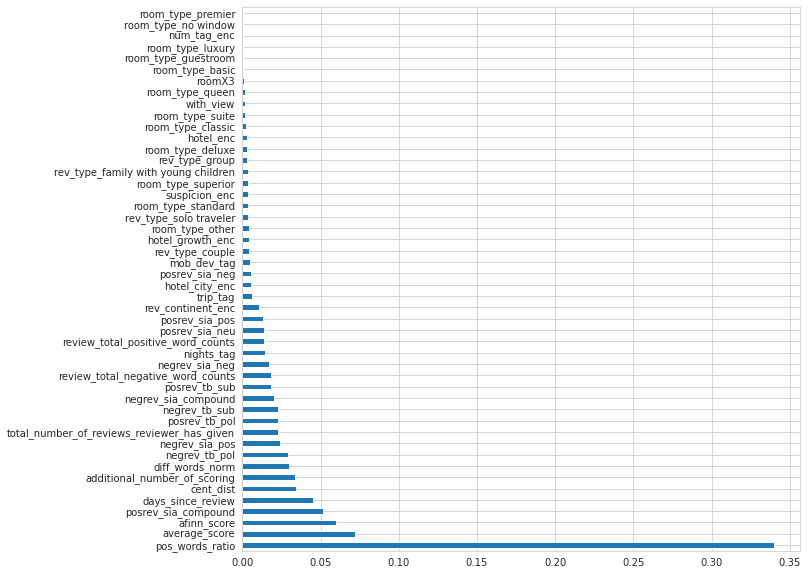

In [128]:
# The most important features for model
plt.rcParams["figure.figsize"] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(50).plot(kind="barh", color="purple")

In [ ]:
# Predict target feature
test_data = test_data.drop(['reviewer_score'], axis=1)
predict_submission = model.predict(test_data)
sample_submission["reviewer_score"] = predict_submission
sample_submission.to_csv("submission.csv", index=False)
sample_submission.head(10)